In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
file_path = "gwas-association.csv"  
gwas_df = pd.read_csv(file_path)

gwas_df.columns = gwas_df.columns.str.strip()

gwas_df["UPSTREAM_GENE_DISTANCE"] = pd.to_numeric(gwas_df["UPSTREAM_GENE_DISTANCE"], errors='coerce')
gwas_df["DOWNSTREAM_GENE_DISTANCE"] = pd.to_numeric(gwas_df["DOWNSTREAM_GENE_DISTANCE"], errors='coerce')

gwas_df["DOWNSTREAM_GENE_DISTANCE"] = gwas_df["DOWNSTREAM_GENE_DISTANCE"] * -1

In [48]:
#(i) Filter for Significant SNPs (p-value < 5E-8) 
significant_snps = gwas_df[gwas_df["P-VALUE"] < 5E-8].copy()

# Classify SNP Locations
def classify_snp_location(row):
    upstream_dist = row["UPSTREAM_GENE_DISTANCE"]
    downstream_dist = row["DOWNSTREAM_GENE_DISTANCE"]
    
    context = str(row["CONTEXT"]).lower() if pd.notna(row["CONTEXT"]) else ""
    within_gene_terms = ["missense_variant", "intron_variant", "coding_sequence_variant", "synonymous_variant"]
    
    if any(term in context for term in within_gene_terms):
        return "WITHIN GENES"
    
    if pd.notna(upstream_dist) and pd.notna(downstream_dist):
        return "UPSTREAM" if upstream_dist < abs(downstream_dist) else "DOWNSTREAM"
    elif pd.notna(upstream_dist):
        return "UPSTREAM"
    elif pd.notna(downstream_dist):
        return "DOWNSTREAM"
    else:
        return None  

significant_snps["SNP_Location"] = significant_snps.apply(classify_snp_location, axis=1)

significant_snps = significant_snps.dropna(subset=["SNP_Location"])

significant_snps.loc[significant_snps["SNP_Location"] == "WITHIN GENES", ["UPSTREAM_GENE_DISTANCE", "DOWNSTREAM_GENE_DISTANCE"]] = 0

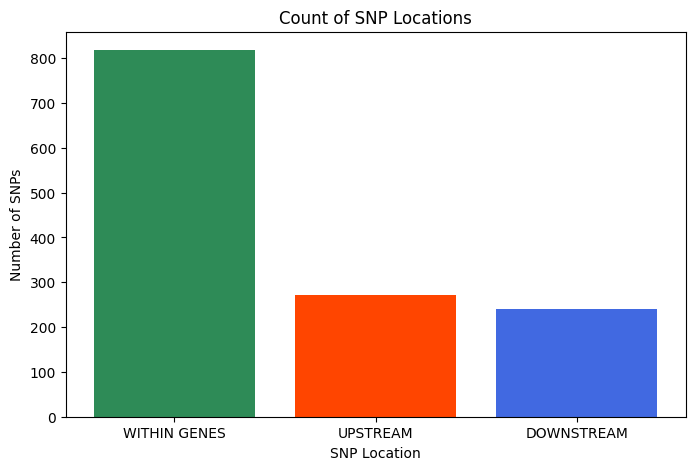

In [49]:
## (ii) Bar Plot: Number of SNPs in Upstream, Downstream, and Within Genes
plt.figure(figsize=(8, 5))
snp_location_counts = significant_snps["SNP_Location"].value_counts()
plt.bar(snp_location_counts.index, snp_location_counts.values, color=["#2E8B57", "#FF4500", "#4169E1"])  # Green, OrangeRed, RoyalBlue
plt.xlabel("SNP Location")
plt.ylabel("Number of SNPs")
plt.title("Count of SNP Locations")
plt.xticks(rotation=0)
plt.show()

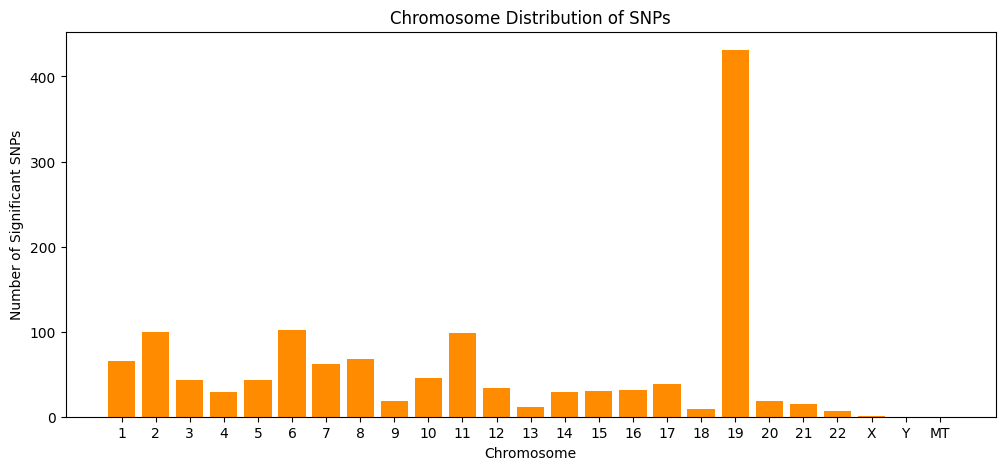

In [50]:
## (iii) Bar Plot: Chromosome Distribution of Significant SNPs
significant_snps["CHR_ID"] = significant_snps["CHR_ID"].astype(str).str.split(';').str[0]

chromosome_order = [str(i) for i in range(1, 23)] + ["X", "Y", "MT"]
significant_snps = significant_snps[significant_snps["CHR_ID"].isin(chromosome_order)] 

chromosome_counts = significant_snps["CHR_ID"].value_counts()
chromosome_counts = chromosome_counts.reindex(chromosome_order).fillna(0)  

plt.figure(figsize=(12, 5))
plt.bar(chromosome_counts.index, chromosome_counts.values, color="#FF8C00")  
plt.xlabel("Chromosome")
plt.ylabel("Number of Significant SNPs")
plt.title("Chromosome Distribution of SNPs")
plt.xticks(rotation=0)
plt.show()

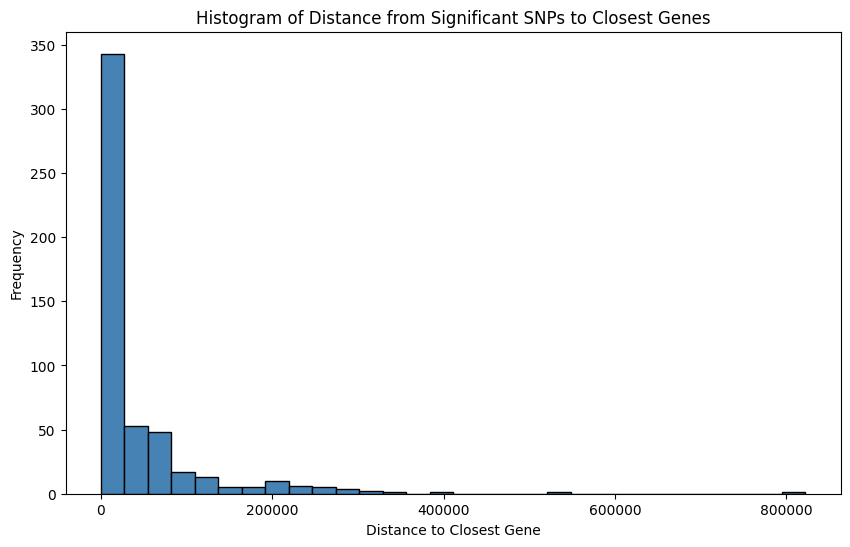

In [51]:
##(iv)

file_path = "gwas-association.csv"  
snp_data = pd.read_csv(file_path)

snp_data.columns = snp_data.columns.str.strip()


snp_data["UPSTREAM_GENE_DISTANCE"] = pd.to_numeric(snp_data["UPSTREAM_GENE_DISTANCE"], errors="coerce")
snp_data["DOWNSTREAM_GENE_DISTANCE"] = pd.to_numeric(snp_data["DOWNSTREAM_GENE_DISTANCE"], errors="coerce")


snp_data["DOWNSTREAM_GENE_DISTANCE"] = snp_data["DOWNSTREAM_GENE_DISTANCE"].abs()

significant_snp_data = snp_data[snp_data["P-VALUE"] < 5E-8].copy()

significant_snp_data["Distance to Closest Gene"] = significant_snp_data[
    ["UPSTREAM_GENE_DISTANCE", "DOWNSTREAM_GENE_DISTANCE"]
].min(axis=1)

significant_snp_data = significant_snp_data.dropna(subset=["Distance to Closest Gene"])

plt.figure(figsize=(10, 6))
plt.hist(significant_snp_data["Distance to Closest Gene"], bins=30, color="#4682B4", edgecolor="black")  

plt.xlabel("Distance to Closest Gene")
plt.ylabel("Frequency")
plt.title("Histogram of Distance from Significant SNPs to Closest Genes")

plt.show()

In [44]:

##(v)

gwas_file = "gwas-association.csv"  
eqtl_file = "EQTL.tsv" 

df_gwas = pd.read_csv(gwas_file)

df_gwas.columns = df_gwas.columns.str.strip()

df_gwas["P-VALUE"] = pd.to_numeric(df_gwas["P-VALUE"], errors="coerce")

df_gwas["UPSTREAM_GENE_DISTANCE"] = pd.to_numeric(df_gwas["UPSTREAM_GENE_DISTANCE"], errors="coerce")

df_gwas["SNPS"] = df_gwas["SNPS"].astype(str).apply(lambda x: "rs" + x if not x.startswith("rs") else x)

significant_snps = df_gwas[df_gwas["P-VALUE"] < 5E-8]

df_upstream_snps = significant_snps[pd.notna(significant_snps["UPSTREAM_GENE_DISTANCE"])]

df_eqtl = pd.read_csv(eqtl_file, sep="\t")

df_eqtl.columns = df_eqtl.columns.str.strip()

brain_tissue_cols = [col for col in df_eqtl.columns if col not in ["rsid", "geneSymbol", "aveALL"]]

df_eqtl[brain_tissue_cols] = df_eqtl[brain_tissue_cols].apply(pd.to_numeric, errors="coerce")

df_eqtl["rsid"] = df_eqtl["rsid"].astype(str)

df_eqtl["min_p_value"] = df_eqtl[brain_tissue_cols].min(axis=1)

df_eqtl["significant_tissues"] = df_eqtl[brain_tissue_cols].apply(
    lambda row: ', '.join(row.index[row < 0.05].tolist()) if (row < 0.05).any() else "None", axis=1
)

df_merged_eqtl = df_upstream_snps.merge(df_eqtl, left_on="SNPS", right_on="rsid", how="inner")


df_eqtl_filtered = df_merged_eqtl[df_merged_eqtl["min_p_value"] < 0.05]

df_eqtl_final = df_eqtl_filtered.groupby(["SNPS", "MAPPED_GENE", "min_p_value"], as_index=False).agg({
    "significant_tissues": lambda x: ', '.join(sorted(set(x))) 
})

df_eqtl_final = df_eqtl_final.rename(columns={
    "SNPS": "eQTL",
    "MAPPED_GENE": "Associated Genes",
    "min_p_value": "p-value",
    "significant_tissues": "Tissues"
})

df_eqtl_final = df_eqtl_final.drop_duplicates()


output_file = "eQTL_Associated_Gene_Results.xlsx"
df_eqtl_final.to_excel(output_file, index=False)


print(df_eqtl_final.head())
print(f" Processed {len(df_eqtl_final)} unique significant eQTLs. Results saved as '{output_file}'.")

          eQTL       Associated Genes   p-value           Tissues
0   rs10402271         BCAM - NECTIN2  0.000120              SNIG
1   rs10792832  RNU6-560P - LINC02695  0.000007  MEDU, TCTX, THAL
2  rs111278892           CNN2 - ABCA7  0.000057              WHMT
3   rs11605427     LINC02705 - MS4A6A  0.000120        HIPP, TCTX
4   rs11605427     LINC02705 - MS4A6A  0.000130              CRBL
 Processed 18 unique significant eQTLs. Results saved as 'eQTL_Associated_Gene_Results.xlsx'.
